In [3]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers.models.m2m_100.modeling_m2m_100 import M2M100Encoder
from transformers.models.t5.modeling_t5 import T5EncoderModel
device = "cuda" if torch.cuda.is_available() else "cpu"

### language identification model

In [4]:
class ClassifierHead(nn.Module):
    def __init__(self,):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 20)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

class LIDModel(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        enc_out = self.encoder(input_ids, attention_mask)
        lhs = enc_out.last_hidden_state
        emb = lhs[:, 0, :]
        # mean_emb = (lhs * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.unsqueeze(-1).sum(1)
        logits = self.classifier(emb)
        return logits

In [6]:
# encoder
model_name = "google/madlad400-3b-mt"
tokenizer = AutoTokenizer.from_pretrained(model_name)
madlad = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir="model")
encoder = madlad.get_encoder()

for p in encoder.parameters():
    p.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/830 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.43M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.8G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [7]:
del madlad
gc.collect()

121

In [8]:
print(encoder)

T5Stack(
  (embed_tokens): Embedding(256000, 1024)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=1024, out_features=2048, bias=False)
            (k): Linear(in_features=1024, out_features=2048, bias=False)
            (v): Linear(in_features=1024, out_features=2048, bias=False)
            (o): Linear(in_features=2048, out_features=1024, bias=False)
            (relative_attention_bias): Embedding(32, 16)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseGatedActDense(
            (wi_0): Linear(in_features=1024, out_features=8192, bias=False)
            (wi_1): Linear(in_features=1024, out_features=8192, bias=False)
            (wo): Linear(in_features=8192, out_features=1024, bias=False)
            (dropout): Dropout(p=0.1, inplace=

In [9]:
# classifier
classifier = ClassifierHead()

In [10]:
# lid model
model = LIDModel(encoder, classifier).to(device)
print(model)
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
print(f"{num_params=} | {trainable_params=} ({round(trainable_params * 100 / num_params, 4)}%)")

LIDModel(
  (encoder): T5Stack(
    (embed_tokens): Embedding(256000, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=2048, bias=False)
              (k): Linear(in_features=1024, out_features=2048, bias=False)
              (v): Linear(in_features=1024, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=8192, bias=False)
              (wi_1): Linear(in_features=1024, out_features=8192, bias=False)
              (wo): Linear(in_features=8192, out_features=1

### language identification dataset

In [11]:
ds = load_dataset("papluca/language-identification")
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

README.md:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [12]:
id2label = sorted(list(set(train_ds['labels'])))
label2id = {x: idx for idx, x in enumerate(id2label)}
print(label2id)

{'ar': 0, 'bg': 1, 'de': 2, 'el': 3, 'en': 4, 'es': 5, 'fr': 6, 'hi': 7, 'it': 8, 'ja': 9, 'nl': 10, 'pl': 11, 'pt': 12, 'ru': 13, 'sw': 14, 'th': 15, 'tr': 16, 'ur': 17, 'vi': 18, 'zh': 19}


In [13]:
def process_fn(x):
    x['labels'] = [label2id[label] for label in x['labels']]
    x['text'] = [f"<2en> {text}" for text in x['text']]
    return x

ds = ds.map(process_fn, batched=True)

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

train_ds[0]

{'labels': 12,
 'text': '<2en> os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fornecer pessoal e financiamento para o centro.'}

In [15]:
def collate_fn(batch):
    batch_tok = tokenizer([x['text'] for x in batch], padding=True, truncation=True, max_length=100, return_tensors="pt").to(device)
    labels = torch.tensor([x['labels'] for x in batch], dtype=torch.int64).to(device)
    return batch_tok, labels

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [17]:
def evaluate(model, ds, batch_size=32, eval_steps=40):
    loss_ls, acc_ls = [], []
    
    model.eval()
    dl = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
    
    with torch.no_grad():
        for idx, (model_inputs, labels) in enumerate(dl):
            logits = model(**model_inputs)
            loss = loss_fn(logits, labels)
            loss_ls.append(loss.item())
    
            preds = logits.argmax(dim=1)
            accuracy = (preds==labels).sum() / batch_size
            acc_ls.append(accuracy.item())
    
            if idx == eval_steps - 1:
                break
    
    model.train()
    
    mean_loss, mean_accuracy = sum(loss_ls) / len(loss_ls), sum(acc_ls) / len(acc_ls)
    return mean_loss, mean_accuracy

In [18]:
def train(model, ds, val_ds, batch_size=32, train_steps=-1, val_steps=100, val_freq=200):
    size = (train_steps * batch_size) if train_steps != -1 else len(ds)
    loss_ls, acc_ls, val_loss_ls, val_acc_ls = [], [], [], []
    
    model.train()
    dl = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
    for idx, (model_inputs, labels) in enumerate(dl):

        # loss
        logits = model(**model_inputs)
        loss = loss_fn(logits, labels)
        loss_ls.append(loss.item())

        # accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds==labels).sum().item() / batch_size
        acc_ls.append(accuracy)
    
        if idx % 40 == 0:
            current = idx * batch_size + labels.shape[0]
            print(f"loss: {loss:>7f} accuracy: {accuracy:>7f} [{current:>5d}/{size:>5d}]")

        # update step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # validation
        if idx % val_freq == 0:
            eval_loss, eval_accuracy = evaluate(model, val_ds, batch_size, val_steps)
            val_loss_ls.append(eval_loss) 
            val_acc_ls.append(eval_accuracy)
            print(f"\nval_loss: {eval_loss:>7f} val_accuracy: {eval_accuracy:>7f}\n")

        if idx == train_steps - 1:
            break

    return {
        "train_loss": loss_ls,
        "train_accuracy": acc_ls,
        "val_loss": val_loss_ls,
        "val_accuracy": val_acc_ls,
    }

In [19]:
history = train(model, train_ds, val_ds, batch_size=128, train_steps=-1, val_steps=-1, val_freq=50)

loss: 2.997225 accuracy: 0.039062 [  128/70000]

val_loss: 2.995853 val_accuracy: 0.049446

loss: 2.988722 accuracy: 0.062500 [ 5248/70000]

val_loss: 2.988788 val_accuracy: 0.119858

loss: 2.934967 accuracy: 0.117188 [10368/70000]

val_loss: 2.780275 val_accuracy: 0.108584

loss: 2.435977 accuracy: 0.125000 [15488/70000]

val_loss: 2.254042 val_accuracy: 0.197389

loss: 2.077522 accuracy: 0.257812 [20608/70000]
loss: 1.898848 accuracy: 0.226562 [25728/70000]

val_loss: 2.108527 val_accuracy: 0.227255

loss: 1.794289 accuracy: 0.320312 [30848/70000]

val_loss: 2.117518 val_accuracy: 0.245945

loss: 1.771854 accuracy: 0.218750 [35968/70000]

val_loss: 1.945952 val_accuracy: 0.280459

loss: 1.610728 accuracy: 0.343750 [41088/70000]

val_loss: 1.918042 val_accuracy: 0.280756

loss: 1.609309 accuracy: 0.375000 [46208/70000]
loss: 1.576872 accuracy: 0.382812 [51328/70000]

val_loss: 2.004276 val_accuracy: 0.293216

loss: 1.518100 accuracy: 0.351562 [56448/70000]

val_loss: 1.940936 val_accu

In [25]:
import matplotlib.pyplot as plt
def plot(name, ls, avg_len=10):
    history = [torch.tensor(ls[idx: idx + avg_len]).mean().item() for idx in range(0, len(ls), avg_len)]
    plt.plot(range(len(history)), history)
    plt.xlabel(f"step / {avg_len}")
    plt.ylabel(name)
    plt.title(f"{name} curve")
    plt.show()

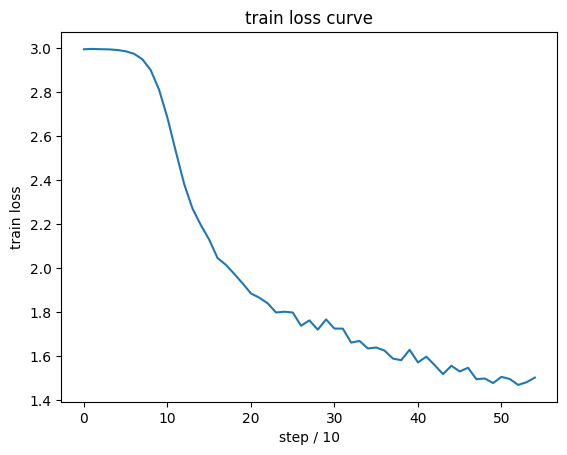

In [26]:
plot("train loss", history['train_loss'], avg_len=10)

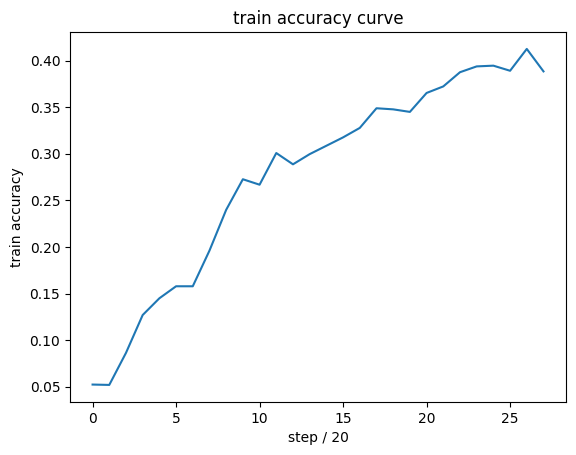

In [27]:
plot("train accuracy", history['train_accuracy'], avg_len=20)

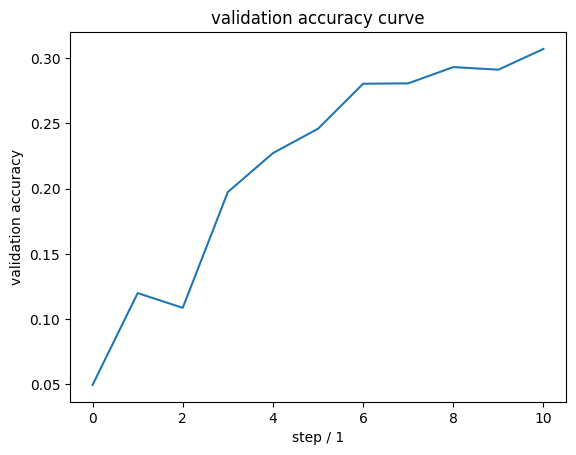

In [28]:
plot("validation accuracy", history['val_accuracy'], avg_len=1)

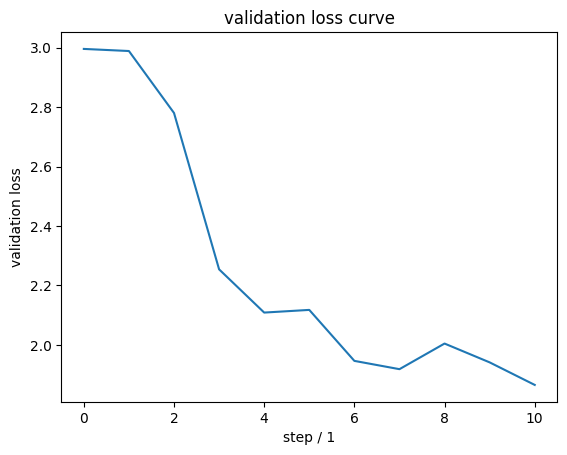

In [29]:
plot("validation loss", history['val_loss'], avg_len=1)

In [ ]:
# inference

model.eval()
idx = 33
print(train_ds[idx])
seq = train_ds[idx]['text']
tok = tokenizer(seq, return_tensors="pt").to("cuda")
logits = model(**tok)
probs = F.log_softmax(logits, dim=1)
print(f"argmax = {probs.argmax(dim=1).item()}")

In [ ]:
# save model checkpoint

torch.save(model.state_dict(), "model.pth")